In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

In [9]:
t_sample = 0.01
T = 100

time_points = torch.linspace(0, T, int(T/t_sample)+1)

In [10]:
class SIR_ODE(nn.Module):

    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, t, x):
        rhs = torch.zeros_like(x)
        # compute SIR model ODE RHS
        rhs[0] = -self.beta*x[0]*x[1]
        rhs[1] = self.beta*x[0]*x[1] - self.gamma*x[1]
        rhs[2] = self.gamma*x[1]
        return rhs

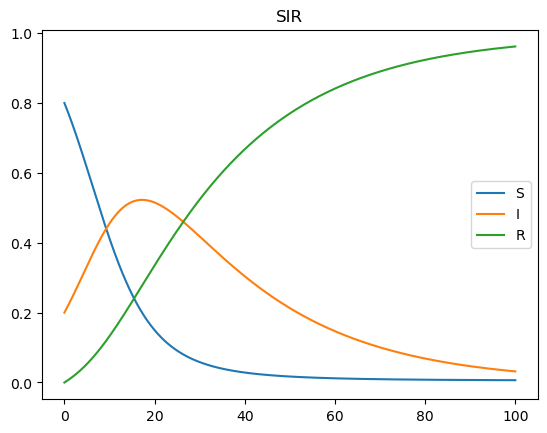

In [12]:
beta = 0.2
gamma = 0.04
x0 = torch.tensor([0.8, 0.2, 0], dtype=torch.float32)

SIR_data = odeint(SIR_ODE(beta, gamma), x0, time_points)


states = ["S","I","R"]

for i in range(3):
    plt.title("SIR")
    plt.plot(time_points, SIR_data[:,i], label=states[i])
    plt.legend()

In [14]:
def objective_function(beta_hat, gamma_hat, initial_condition, observed_data, time_points):
    predicted_data = odeint(SIR_ODE(beta_hat, gamma_hat), initial_condition, time_points)
    return nn.MSELoss()(predicted_data, observed_data)

In [16]:
beta_hat = torch.tensor(0, dtype=torch.float32, requires_grad=True)
gamma_hat = torch.tensor(0, dtype=torch.float32, requires_grad=True)
initial_condition = torch.tensor([0,0,0], dtype=torch.float32, requires_grad=True)

optimizer = optim.Adam([beta_hat, gamma_hat, initial_condition], lr=0.01)

num_epochs = 300

losses = []
thetas = []
inits = []

# Optimization loop
for epoch in range(num_epochs):
    # Compute loss
    loss = objective_function(beta_hat, gamma_hat, initial_condition, SIR_data, time_points)
    # Zero gradients
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Update parameters
    optimizer.step()

    losses.append(loss.detach().item())
    # thetas.append(theta_hat.detach().item())
    # inits.append(initial_condition.detach().item())

# Obtain the learned parameters
# learned_parameters = theta_hat.detach().numpy()
learned_init = initial_condition.detach().numpy()

# losses = np.array(losses)
# thetas = np.array(thetas)
# inits = np.array(inits)

In [17]:
beta_hat

tensor(0.1905, requires_grad=True)

In [18]:
gamma_hat

tensor(0.0391, requires_grad=True)

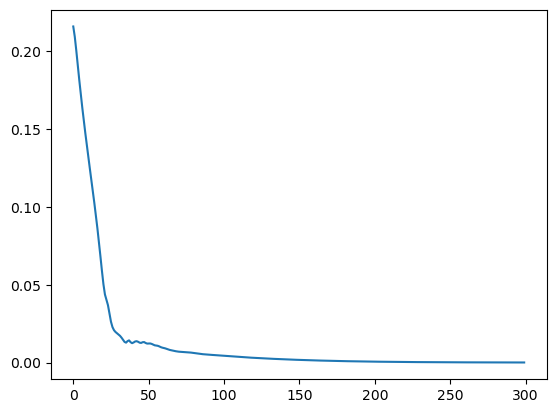

In [19]:
plt.plot(losses)

In [20]:
learned_init

array([0.7745103 , 0.2183445 , 0.01247808], dtype=float32)